In [133]:
from flask import Flask, render_template, request, redirect
from bs4 import BeautifulSoup
import requests
import urllib2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [171]:
def get_sal_data(season):
    data_list = []
    cap = requests.get('http://www.spotrac.com/nba/cap/'+str(season)+'/')
    soup= BeautifulSoup(cap.text,"html.parser")
    table = soup.find('div',{'id':'main','class':' xlarge'}).find()
    sal_cap = str(table)[int(str(table).find('$')+1):int(str(table).find('<br>'))]
    cap_value = float(sal_cap.replace(',',''))/10000
    for pos in ['point-guard','shooting-guard','small-forward','power-forward','center']:
        pos_num = ['point-guard','shooting-guard','small-forward','power-forward','center'].index(pos)
        contract = requests.get('http://www.spotrac.com/nba/rankings/'+str(season)+'/cap-hit/'+pos+'/')
        soup_new= BeautifulSoup(contract.text,"html.parser")
        table = soup_new.find('table',{'class':'datatable noborder'})
        l = table.tbody.find_all('tr')

        for i in l:
            row = [j.get_text().encode('utf-8') for j in i.find_all('td')]
            name = row[2].split('\n')[1]
            sal = int(int(row[3].split('$')[1].replace(',',''))/10000)
            ratio = float(sal)/cap_value
            data_list.append([name,int(pos_num),sal,ratio])
    return data_list

In [836]:
def get_player_data(year):
    advanced_train = 'http://www.basketball-reference.com/leagues/NBA_'+str(year)+'_advanced.html'
    req = requests.get(advanced_train)
    text = BeautifulSoup(req.text, 'html.parser')
    stats = text.find('div',{'id': 'all_advanced_stats'})
    P_list = ['PG','SG','SF','PF','C']
    per_data = {}
    age_data = {}
    min_data = {}
    wS_data = {}
    vorp_data = {}
    off_pos = {}
    for i in stats.tbody.find_all('tr'):

        row = [j.get_text().encode('utf-8') for j in i.find_all('td')]

        if len(row)==0:
            continue
        mins = row[5]
        gp = row[4]
        mp = float(mins)/float(gp)
        age = int(row[2])
        if float(mp) > 8.0 and float(gp)>10 and age>24:
            name = str(row[0])
            per = float(row[6])
            #ws per game to adjust for injury
            wS = float(row[21])
            vorp = float(row[27])
            pos = str(row[1])
            if len(pos)>2:
                plist = pos.split('-')
                pos = plist[0]
            pos_num = P_list.index(pos)
            if name not in per_data.keys() and per>=0 and wS>=0:
                per_data.update({name:per})
                age_data.update({name:age})
                min_data.update({name:mp})
                wS_data.update({name:wS})
                off_pos.update({name:pos_num})
                vorp_data.update({name:vorp})
    return per_data,age_data,min_data,wS_data,off_pos,vorp_data

In [837]:
plotting_data = []
knn_test = []
total_data = []
total_names = []
total_testname = []
total_test = []
test_data = [[],[],[],[],[]]
test_names = [[],[],[],[],[]]
cul_data = [[],[],[],[],[]]
names_data = [[],[],[],[],[]]
for season in [2010,2011,2012,2013,2014,2015,2016]:
    print season
    year = season+1
    data_list = get_sal_data(season)
    per_data,age_data,min_data,wS_data,off_pos,vorp_data = get_player_data(year)
    for player in data_list:
        name = player[0]
        pos = player[1]
        salary = player[2]
        ratio = player[3]
        if name in per_data.keys() and salary>50:
            PER = per_data[name]
            WS = wS_data[name]
            off_Pos = off_pos[name]
            age = age_data[name]
            VORP = vorp_data[name]
            vet = int(age>=35)
           # roo = int(age<25)
            mp = min_data[name]
            ind = [0,0,0,0,0]
            if off_Pos==pos:
                ind[pos] = 1
                total_names.append(name)
                total_data.append([age,salary,ratio,mp,VORP,PER**2,WS,PER,mp*PER]+ind)
                cul_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,mp*PER,age])
                names_data[pos].append(name)
            else:
                ind[pos] = 0.5
                ind[off_Pos]=0.5
                total_names.append(name)
                total_data.append([age,salary,ratio,mp,VORP,PER**2,WS,PER,mp*PER]+ind)
                cul_data[off_Pos].append([salary,ratio,mp,PER,PER**2,WS,vet,mp*PER,age])
                names_data[off_Pos].append(name)
                cul_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,mp*PER,age])
                names_data[pos].append(name)
            plotting_data.append([PER,WS,ratio])
t_season = 2017
t_year = 2018
data_test = get_sal_data(t_season)
per_test,age_test,min_test,wS_test,off_test,vorp_test = get_player_data(t_year)

for player in data_test:
        name = player[0]
        pos = player[1]
        salary = player[2]
        ratio = player[3]
        if name in per_test.keys() and salary>50:
            PER = per_test[name]
            age = age_test[name]
            WS = wS_test[name]
            vorp = vorp_test[name]
            OFF_POS = off_test[name]
            vet = int(age>=35)
            #roo = int(age<25)
            mp = min_test[name]
            ind=[0,0,0,0,0]
            if OFF_POS==pos:
                ind[pos]=1
                total_testname.append(name)
                total_test.append([age,salary,ratio,mp,vorp,PER**2,WS,PER,mp*PER]+ind)
                test_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                test_names[pos].append(name)
            else:
                ind[pos] = 0.5
                ind[OFF_POS]=0.5
                total_testname.append(name)
                total_test.append([age,salary,ratio,mp,vorp,PER**2,WS,PER,mp*PER]+ind)
                test_data[OFF_POS].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                test_names[OFF_POS].append(name)
                test_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                test_names[pos].append(name)
            knn_test.append([PER,WS,ratio])

2010
2011
2012
2013
2014
2015
2016


In [843]:
ALL_SAL = []
ALL_PRED = []
ALL_NAMES = []
#X include PER,VORP,VET,MP*PER,INDICATORS
TRAIN_Y = np.array(total_data)[:,2]
TRAIN_Z = np.array(total_data)[:,1]
TRAIN_X = np.array(total_data)[:,6:]
TEST_Y = np.array(total_test)[:,2]
TEST_Z = np.array(total_test)[:,1]
TEST_X = np.array(total_test)[:,6:]
regr = HuberRegressor(epsilon=1)
regr.fit(TRAIN_X,TRAIN_Y)
test_pred = regr.predict(TEST_X)
total_pred = regr.predict(TRAIN_X)
print "MAE = "+str(mean_absolute_error(TEST_Z,9909*test_pred))
print "Test R^2 = "+str(regr.score(TEST_X,TEST_Y))
print "Train R^2 = "+str(regr.score(TRAIN_X,TRAIN_Y))   
print regr.coef_,regr.intercept_
test_SAL = TEST_Z
test_PRED = 9909*test_pred
ALL_RATIO = TRAIN_Y
ALL_PRED = total_pred


MAE = 412.874754963
Test R^2 = 0.581280385396
Train R^2 = 0.55434031695
[-0.00652719 -0.00527774  0.00048289 -0.01375509 -0.01284177  0.00440119
  0.01184942  0.02707469] 0.0167122889116


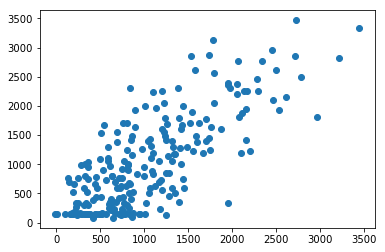

In [855]:
plt.scatter(test_PRED,test_SAL)

In [860]:
Pred_show = []
cur_cap = 9909
for i in range(len(total_testname)):
    name = total_testname[i]
    per = round(total_test[i][7],1)
    age = int(total_test[i][0])
    mp = round(total_test[i][3],1)
    ws = round(total_test[i][6],2)
    #vorp = round(TEST_X[i][1],1)
    sal_pred = int(test_PRED[i])
    true_sal = int(TEST_Z[i])
    Pred_show.append([true_sal,sal_pred,name,per,ws,mp,age])
sorted(Pred_show,reverse=True)

[[3468, 2716, 'Stephen Curry', 29.5, 5.6, 32.5, 29],
 [3328, 3441, 'LeBron James', 29.8, 7.7, 36.8, 33],
 [3126, 1782, 'Paul Millsap', 17.5, 1.1, 29.7, 32],
 [2951, 2451, 'Blake Griffin', 20.8, 2.4, 34.3, 28],
 [2870, 1735, 'Kyle Lowry', 19.3, 4.9, 32.8, 31],
 [2853, 2714, 'Russell Westbrook', 25.2, 5.4, 36.1, 29],
 [2853, 1526, 'Mike Conley', 16.0, 0.7, 31.1, 30],
 [2829, 3213, 'James Harden', 30.4, 8.0, 36.3, 28],
 [2773, 2334, 'DeMar DeRozan', 23.8, 6.0, 34.5, 28],
 [2773, 2068, 'Al Horford', 19.1, 5.2, 32.5, 31],
 [2624, 1570, 'Carmelo Anthony', 14.2, 2.5, 32.8, 33],
 [2615, 2496, 'Damian Lillard', 22.6, 4.7, 36.6, 27],
 [2565, 1794, 'Jrue Holiday', 15.6, 2.4, 36.6, 27],
 [2500, 2782, 'Kevin Durant', 25.2, 5.0, 34.6, 29],
 [2459, 2274, 'Chris Paul', 24.9, 4.1, 32.0, 32],
 [2396, 1952, 'C.J. McCollum', 17.5, 3.7, 36.6, 26],
 [2377, 2055, 'Hassan Whiteside', 25.0, 2.4, 25.8, 28],
 [2350, 1950, 'Dwight Howard', 18.2, 2.3, 30.1, 32],
 [2311, 1968, 'Harrison Barnes', 16.5, 2.5, 34.8, 25

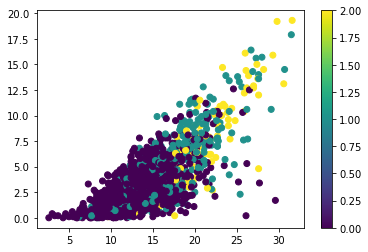

In [565]:
#classification analysis
low_cut = 0.15
high_cut = 0.28
PER_ = np.array(plotting_data)[:,0]
WS_ = np.array(plotting_data)[:,1]
trainX = np.array(plotting_data)[:,0:2]
X_ = np.array(knn_test)[:,0:2]
y_ = np.array(knn_test)[:,2]
y_class = (y_>low_cut)*1+(y_>high_cut)*1
sal_ = np.array(plotting_data)[:,2]
sal_ind = (sal_>low_cut)*1+(sal_>high_cut)*1
plt.scatter(PER_,WS_,c=sal_ind)
plt.colorbar()

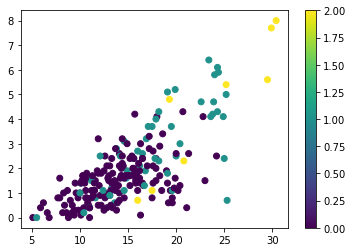

In [566]:
plt.scatter(X_[:,0],X_[:,1],c=y_class)
plt.colorbar()

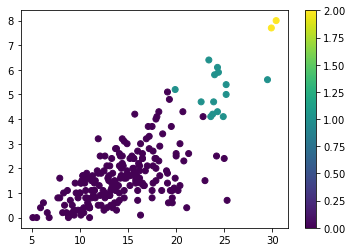

In [570]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=35)
neigh.fit(trainX, sal_ind)
train_pred = neigh.predict(trainX)
classified = neigh.predict(X_)
plt.scatter(X_[:,0],X_[:,1],c=classified)
plt.colorbar()

In [571]:
#training accuracy
print sum((train_pred-sal_ind)==0)*1.0/len(sal_ind)
#testing accuracy
print sum((classified-y_class)==0)*1.0/len(y_class)

0.795411089866
0.79203539823


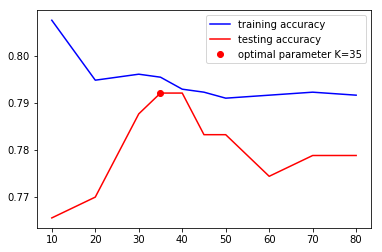

In [569]:
#grid search
train_list = []
test_list = []
K_list = [10,20,30,35,40,45,50,60,70,80]
for K in K_list:
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(trainX, sal_ind)
    train_pred = neigh.predict(trainX)
    classified = neigh.predict(X_)
    train_acc = sum((train_pred-sal_ind)==0)*1.0/len(sal_ind)
    test_acc = sum((classified-y_class)==0)*1.0/len(y_class)
    train_list.append(train_acc)
    test_list.append(test_acc)
opt_k = K_list[test_list.index(max(test_list))]
plt.plot(K_list,train_list,'b',label='training accuracy')    
plt.plot(K_list,test_list,'r',label='testing accuracy')
plt.plot(opt_k,max(test_list),'ro',label='optimal parameter K='+str(opt_k))
plt.legend()


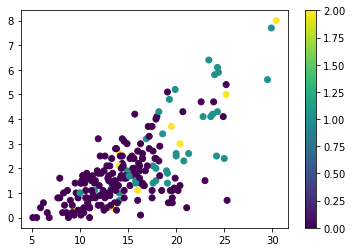

In [579]:
#DCT
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(trainX, sal_ind)
trainY = clf.predict(trainX)
Y_ = clf.predict(X_)
plt.scatter(X_[:,0],X_[:,1],c=Y_)
plt.colorbar()

In [578]:
#training accuracy
print sum((trainY-sal_ind)==0)*1.0/len(sal_ind)
#testing accuracy
print sum((Y_-y_class)==0)*1.0/len(y_class)

0.810070108349
0.734513274336


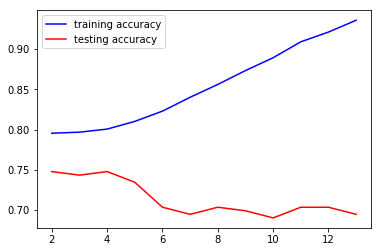

In [575]:
train_list = []
test_list = []
depth_list = [2,3,4,5,6,7,8,9,10,11,12,13]
for depth in depth_list:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(trainX, sal_ind)
    trainY = clf.predict(trainX)
    Y_ = clf.predict(X_)
  
    train_acc = sum((trainY-sal_ind)==0)*1.0/len(sal_ind)
    test_acc = sum((Y_-y_class)==0)*1.0/len(y_class)
    train_list.append(train_acc)
    test_list.append(test_acc)
plt.plot(depth_list,train_list,'b',label='training accuracy')    
plt.plot(depth_list,test_list,'r',label='testing accuracy')
plt.legend()

In [668]:
all_sal = []
all_pred = []
all_names = []

In [685]:
#prepare data for regression models
i = 4
#select a position 0-PG, 1-SG, 2-SF, 3-PF, 4-C
cur_data = np.array(cul_data[i])
cur_names = names_data[i]
if i==1:
    cur_data = np.array(cul_data[1]+cul_data[0])
    cur_names = names_data[1]+names_data[0]
#if i==4:
    #cur_data = np.array(cul_data[3]+cul_data[4])
    #cur_names = names_data[3]+names_data[4]
cur_testname = test_names[i]
cur_test = np.array(test_data[i])
Z = cur_data[:,0]
Y = cur_data[:,1]
X = cur_data[:,2:-1]
testX = cur_test[:,2:-1]
testY = cur_test[:,1]
testZ = cur_test[:,0]

In [686]:
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.metrics import mean_absolute_error
#from sklearn.cross_validation import KFold
#kf = KFold(len(Wins),n_folds=5,shuffle=True)
#pred=[]
#test case Memphis Grizzlies
#clf = Lasso(alpha=0.1)
#clf = LinearRegression()
#epsilon=1 for C,PF,SG,5 for PG,3 for SF
clf = HuberRegressor(epsilon=1,alpha=0)
    # Iterate through folds
#regr.fit(X,Y)
clf.fit(X,Y)
pred = clf.predict(np.array(testX))
print "MAE = "+str(mean_absolute_error(testZ,9909*pred))
print "Test R^2 = "+str(clf.score(testX,testY))
print "Train R^2 = "+str(clf.score(X,Y))   
print clf.coef_,clf.intercept_
all_sal.extend(testZ)
all_pred.extend(9909*pred)
all_names.extend(cur_testname)

MAE = 415.314722296
Test R^2 = 0.511301687095
Train R^2 = 0.549206831834
[  2.34851775e-03  -3.02986786e-03  -5.13931514e-05  -6.32776724e-03
   6.21444475e-04   0.00000000e+00   4.00999095e-04] 0.000328999854055


In [610]:
pred_show = []
cur_cap = 9909
for i in range(len(cur_testname)):
    name = cur_testname[i]
    per = round(testX[i][1],1)
    age = int(cur_test[i][-1])
    mp = round(testX[i][0],1)
    ws = round(testX[i][3],1)
    sal_pred = int(pred[i]*cur_cap)
    true_sal = int(testZ[i])
    pred_show.append([true_sal,sal_pred,name,per,ws,mp,age])
sorted(pred_show,reverse=True)

[[3328, 3338, 'LeBron James', 29.9, 7.7, 37.0, 33],
 [3126, 1678, 'Paul Millsap', 17.5, 1.1, 29.7, 32],
 [2951, 2360, 'Blake Griffin', 20.8, 2.3, 34.3, 28],
 [2624, 1504, 'Carmelo Anthony', 14.2, 2.5, 32.8, 33],
 [2500, 2725, 'Kevin Durant', 25.2, 5.0, 34.6, 29],
 [2311, 1909, 'Harrison Barnes', 16.5, 2.6, 34.8, 25],
 [2146, 2526, 'LaMarcus Aldridge', 24.4, 5.9, 33.8, 32],
 [2006, 1394, 'Serge Ibaka', 16.0, 2.7, 28.3, 28],
 [1957, 1030, 'Ryan Anderson', 12.1, 2.5, 28.4, 29],
 [1669, 1414, 'Robert Covington', 13.8, 2.8, 32.3, 27],
 [1640, 1722, 'Draymond Green', 17.1, 3.7, 31.8, 27],
 [1600, 1889, 'Tobias Harris', 18.2, 4.3, 32.8, 25],
 [1600, 1339, 'Pau Gasol', 19.5, 3.7, 24.8, 37],
 [1479, 1490, 'Thaddeus Young', 14.4, 2.5, 32.2, 29],
 [1400, 1670, 'Taj Gibson', 15.7, 4.2, 33.5, 32],
 [1395, 1250, 'James Johnson', 15.5, 2.0, 26.5, 30],
 [1316, 1028, 'Marvin Williams', 13.7, 2.8, 25.8, 31],
 [1292, 562, 'Kenneth Faried', 19.1, 1.4, 15.3, 28],
 [1258, 853, 'Cody Zeller', 16.0, 1.1, 19.9

In [687]:
from sklearn.cluster import KMeans
KM_data = zip(all_sal,all_pred)
kmeans = KMeans(n_clusters=3, random_state=0).fit(KM_data)

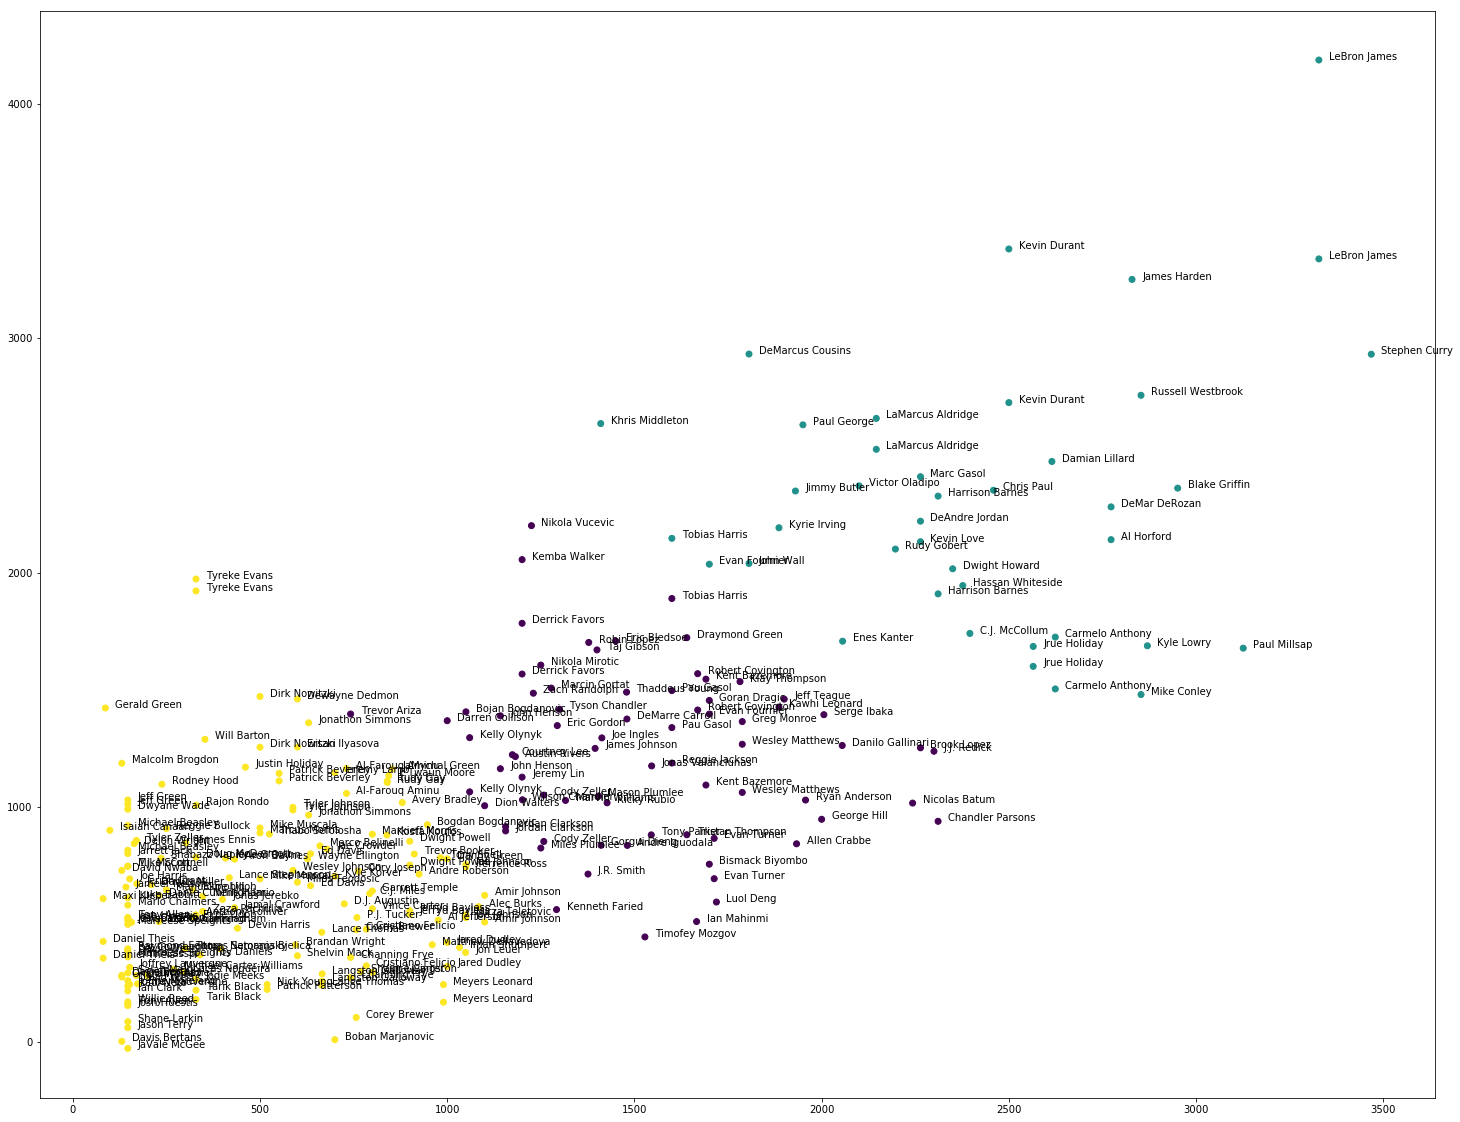

In [705]:
fig = plt.figure(figsize=(25,20))

ax = fig.add_subplot(111)

plt.scatter(all_sal,all_pred,c=kmeans.labels_)
for i in range(len(KM_data)):
    ax.annotate(all_names[i], xy=(all_sal[i],all_pred[i]), xytext=(10,0), textcoords='offset points')

plt.show()

In [711]:
regr2 = LinearRegression()
x2 = np.array(all_pred)
X2 = zip(x2,x2**2)
y2 = np.array(all_sal)
regr2.fit(X2,y2)
y2_pred = regr2.predict(X2)
print regr2.score(X2,y2)
print mean_absolute_error(y2,y2_pred)
print mean_absolute_error(all_sal,all_pred)

0.559359843983
422.431394771
426.341680055
